In [1]:
%pylab inline

import pandas as pd
import pickle
import matplotlib.dates as md
import statsmodels.api as sm
import scipy.stats as dists

from scipy.optimize import minimize

tableau = pickle.load(open('tableau.colors', 'rb'))

rcParams['figure.figsize'] = (10,8)
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler('color', tableau)

xfmt = md.DateFormatter('%H:%M:%S')

Populating the interactive namespace from numpy and matplotlib


In [8]:
hardcoded = pd.read_csv('~/Downloads/coinbaseUSD.csv', header=0, names=['t', 'px', 'sz'])

In [9]:
df = hardcoded.copy()
df.t *= 1e9
df.t = pd.to_datetime(df.t)
df['pxd'] = df.px - df.px.shift(1)
df['d'] = 1*(df.pxd > 0) - 1*(df.pxd < 0)

# Eliminate early data with insufficient liquidity.
df = df.loc[df.t > "2015-09-03"]

In [3]:
def front(df, stamp, days=1):
    sliced = df.loc[(df.t - pd.to_datetime(stamp)) > pd.Timedelta(days=0)]
    sliced = sliced.loc[(sliced.t - pd.to_datetime(stamp)) < pd.Timedelta(days=days)]
    return sliced

def around(df, stamp, size):
    sliced = df.loc[abs(df.t - pd.to_datetime(stamp)) < pd.Timedelta(days=size/24.)]
    return sliced

def vwap(df, window):
    return (df.px * df.sz).rolling(window).sum() / df.sz.rolling(window).sum()

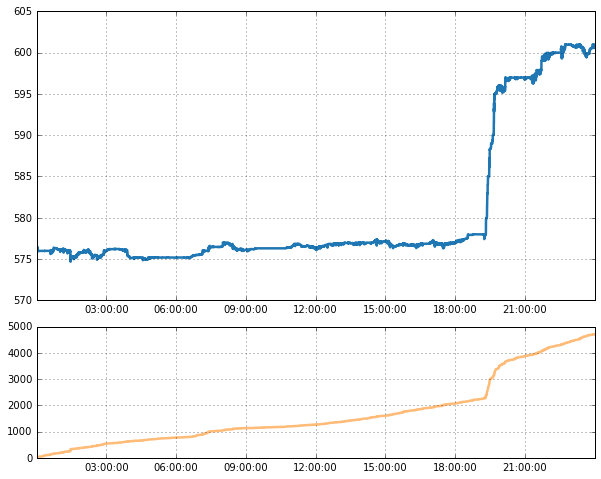

In [6]:
data = front(df, '2016-09-03')

ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

ax[0].plot(data.t, data.px)
ax[1].plot(data.t, data.sz.cumsum(), c=tableau[3])

ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)

In [48]:
# Glosten-Milgrom Model
def traded(row, prob, alpha, eta):
    newprob = prob.copy()
    modup = (1 - alpha)*eta + alpha 
    moddn = (1 - alpha) - (1 - alpha)*eta  
    
    idx = int(100*row.px + 4*sigma - v0)
    if row.d == -1:
        newprob[idx+1:] *= modup
        newprob[:idx+1] *= moddn
    elif row.d == 1:
        newprob[:idx] *= modup
        newprob[idx:] *= moddn
    return newprob/newprob.sum()

def compute(data, vals, prob, steps, xk):
    alpha = xk[0]; eta = xk[1]
    bests = ndarray(steps+1)
    probs = ndarray((steps+1, len(prob)))
    for i in range(steps+1):
        probs[i] = prob.copy() if i == 0 else traded(data.iloc[i], probs[i-1], alpha, eta)
        bests[i] = (vals*probs[i]).sum()
    return bests, probs

def setup_model(data, sigma):
    v0 = 100 * (data.iloc[0].px)
    sigma = sigma*100
    #sigma = (v0 * sigma)*sqrt((data.iloc[-1].t - data.iloc[0].t).total_seconds() / (60*60*24))
    vals = (v0 - 4*sigma + arange(int(8*sigma) + 1))/100
    prob = dists.norm.pdf(v0 - 4*sigma + arange(len(vals)), loc=v0, scale=sigma)
    return v0, sigma, prob, vals

def estimate(data, xk, n, model):
    v0, sigma, prob, vals = model
    alpha = xk[0]
    eta = xk[1]
   
    bests, probs = compute(data, vals, prob, len(data)-1, [alpha, eta])
    return (bests - data.px.rolling(n).mean().shift(-n))[:-n]

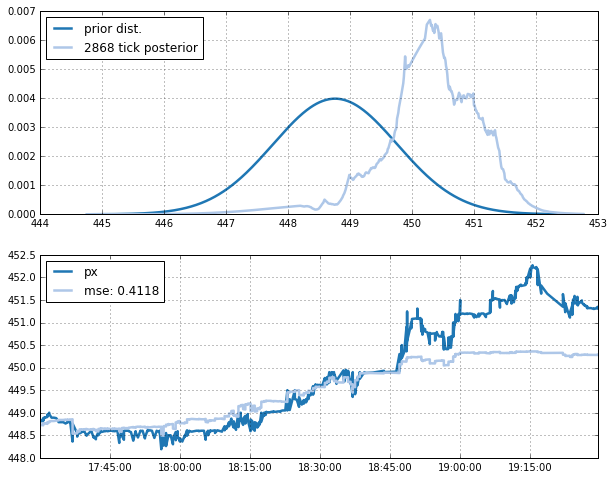

In [57]:
data = around(df, '2016-05-03 18:30:00', 1)
v0, sigma, prob, vals = setup_model(data, 1.00)

bests, probs = compute(data, vals, prob, len(data)-1, [0.01, 0.50])
mse = ((bests - data.px.shift(-50))[:-50]**2).mean()

ax = []
ax.append(subplot2grid((2,1),(0,0)))
ax.append(subplot2grid((2,1),(1,0)))

ax[0].plot(vals, prob, label='prior distribution')
ax[0].plot(vals, probs[-1], label='%d tick posterior' % (len(data)-1))
ax[0].legend(loc='upper left')

ax[1].plot(data.t, data.px)
ax[1].plot(data.t, bests, label="mse: %0.4f" % mse)
ax[1].xaxis.set_major_formatter(xfmt)
ax[1].legend(loc='upper left')

In [74]:
data = around(df, '2016-03-03 18:30:00', 1)
v0, sigma, prob, vals = setup_model(data, 1.00)

def obj(xk):
    return (estimate(data, xk, 10, model=(v0, sigma, prob, vals))**2).std()

cons = [{'type': 'ineq', 'fun': lambda params: params[0]},
        {'type': 'ineq', 'fun': lambda params: 1 - params[0]},
        {'type': 'ineq', 'fun': lambda params: params[1]},
        {'type': 'ineq', 'fun': lambda params: 1 - params[1]}]
res = minimize(obj, [0.01, 0.50], constraints=cons)
res

     fun: 0.9856616821176772
     jac: array([ 0.01624721,  0.02697789,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.08813245,  0.44918414])

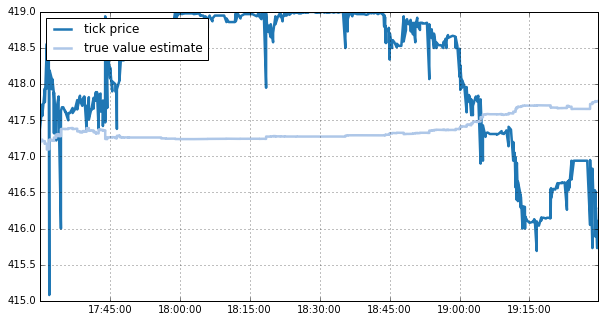

In [78]:
data = around(df, '2016-03-03 18:30:00', 1)
v0, sigma, prob, vals = setup_model(data, 1.00)

bests, probs = compute(data, vals, prob, len(data)-1, res['x'])

ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))

ax[0].plot(data.t, data.px, label='tick price')
ax[0].plot(data.t, bests, label='true value estimate')
ax[0].xaxis.set_major_formatter(xfmt)
ax[0].legend(loc='upper left')

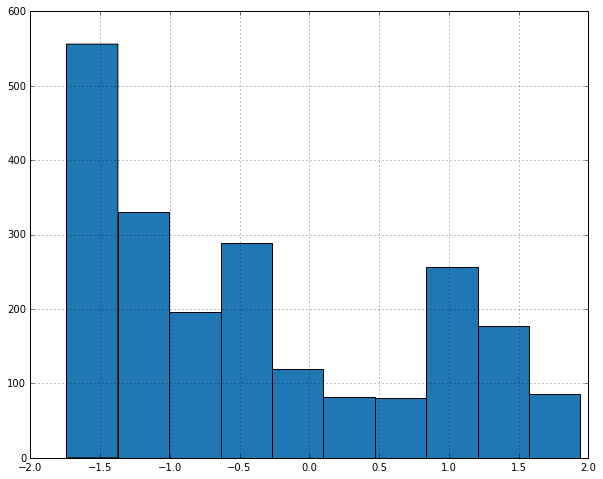

In [81]:
error = estimate(data, res['x'], 10, model=(v0, sigma, prob, vals))
error.hist()

In [80]:
print((error**2).mean(),(error**2).std())

1.289705502175945 1.1447386563842505


In [70]:
(data.t - data.t.shift(1)).mean().total_seconds()

3.2920678580000002